In [1]:
import pandas as pd

# Load the dataset
traffic_df = pd.read_csv('Dataset_Uber Traffic.csv')

# Check basic info
print("Shape of the dataset:", traffic_df.shape)
print("\nColumn names:\n", traffic_df.columns)

# Display first few rows
traffic_df.head()

Shape of the dataset: (48120, 4)

Column names:
 Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')


,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [2]:
# Convert DateTime to proper datetime object
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M')

# Extract Date and Hour (to merge later)
traffic_df['Date'] = traffic_df['DateTime'].dt.date
traffic_df['Hour'] = traffic_df['DateTime'].dt.hour

# Optional: Rearranging columns for clarity
traffic_df = traffic_df[['DateTime', 'Date', 'Hour', 'Junction', 'Vehicles', 'ID']]

# Quick preview
traffic_df.head()

,DateTime,Date,Hour,Junction,Vehicles,ID
0,2015-11-01 00:00:00,2015-11-01,0,1,15,20151101001
1,2015-11-01 01:00:00,2015-11-01,1,1,13,20151101011
2,2015-11-01 02:00:00,2015-11-01,2,1,10,20151101021
3,2015-11-01 03:00:00,2015-11-01,3,1,7,20151101031
4,2015-11-01 04:00:00,2015-11-01,4,1,9,20151101041


In [3]:
# Load the weather data
weather_df = pd.read_csv('weather_data.csv')

# Convert date columns (if needed)
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
traffic_df['Date'] = pd.to_datetime(traffic_df['Date'])

# Merge with traffic data
merged_df = pd.merge(traffic_df, weather_df, on=['Date', 'Hour'], how='left')

# Check result
merged_df.head()

,DateTime_x,Date,Hour,Junction,Vehicles,ID,DateTime_y,Temperature(C),Humidity(%),Precipitation(mm),WindSpeed(kmph),Conditions
0,2015-11-01 00:00:00,2015-11-01,0,1,15,20151101001,2015-11-01 00:00:00,25.5,63.0,0.0,6.7,Clear
1,2015-11-01 01:00:00,2015-11-01,1,1,13,20151101011,2015-11-01 01:00:00,37.0,92.0,0.0,11.6,Fog
2,2015-11-01 02:00:00,2015-11-01,2,1,10,20151101021,2015-11-01 02:00:00,32.6,45.0,0.0,11.1,Clear
3,2015-11-01 03:00:00,2015-11-01,3,1,7,20151101031,2015-11-01 03:00:00,30.0,82.0,0.0,8.1,Clear
4,2015-11-01 04:00:00,2015-11-01,4,1,9,20151101041,2015-11-01 04:00:00,21.1,99.0,0.1,1.3,Clear


In [4]:
# Load event data
events_df = pd.read_csv('events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])

# Merge with your traffic-weather dataset
merged_df = pd.merge(merged_df, events_df, on='Date', how='left')
## Feature Engineering
# Fill in missing values (non-event days)
merged_df['Is_Event'] = merged_df['Is_Event'].fillna(0)
merged_df['Event_Name'] = merged_df['Event_Name'].fillna('None')

# Preview
merged_df.head()

,DateTime_x,Date,Hour,Junction,Vehicles,ID,DateTime_y,Temperature(C),Humidity(%),Precipitation(mm),WindSpeed(kmph),Conditions,Event_Name,Is_Event
0,2015-11-01 00:00:00,2015-11-01,0,1,15,20151101001,2015-11-01 00:00:00,25.5,63.0,0.0,6.7,Clear,None,0.0
1,2015-11-01 01:00:00,2015-11-01,1,1,13,20151101011,2015-11-01 01:00:00,37.0,92.0,0.0,11.6,Fog,None,0.0
2,2015-11-01 02:00:00,2015-11-01,2,1,10,20151101021,2015-11-01 02:00:00,32.6,45.0,0.0,11.1,Clear,None,0.0
3,2015-11-01 03:00:00,2015-11-01,3,1,7,20151101031,2015-11-01 03:00:00,30.0,82.0,0.0,8.1,Clear,None,0.0
4,2015-11-01 04:00:00,2015-11-01,4,1,9,20151101041,2015-11-01 04:00:00,21.1,99.0,0.1,1.3,Clear,None,0.0


In [5]:
## Model Training and Evaluation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Drop extra datetime columns to avoid confusion
df = merged_df.copy()
df = df.drop(columns=['DateTime_x', 'DateTime_y'])

# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# One-hot encode 'Conditions' and 'Event_Name'
categorical_features = ['Conditions', 'Event_Name']
numerical_features = ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'WindSpeed(kmph)', 'Hour', 'Junction', 'Is_Event']

# Define target
target = 'Vehicles'

# Prepare features and labels
X = df[categorical_features + numerical_features]
y = df[target]

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create full pipeline with model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 6.26
RMSE: 9.26
R²: 0.1370


In [7]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt

# Create time-based cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate with cross_val_score using negative MAE
cv_scores = cross_val_score(model_pipeline, X, y, cv=tscv, scoring='neg_mean_absolute_error')

# Convert negative MAE to positive
cv_mae_scores = -cv_scores

print("Cross-Validation MAEs:", cv_mae_scores)
print(f"Mean CV MAE: {cv_mae_scores.mean():.2f}")

Cross-Validation MAEs: [18.84943629 21.41928303  6.97702355  5.88941708  6.69239943]
Mean CV MAE: 11.97


In [8]:
## Plot actual vs predicted

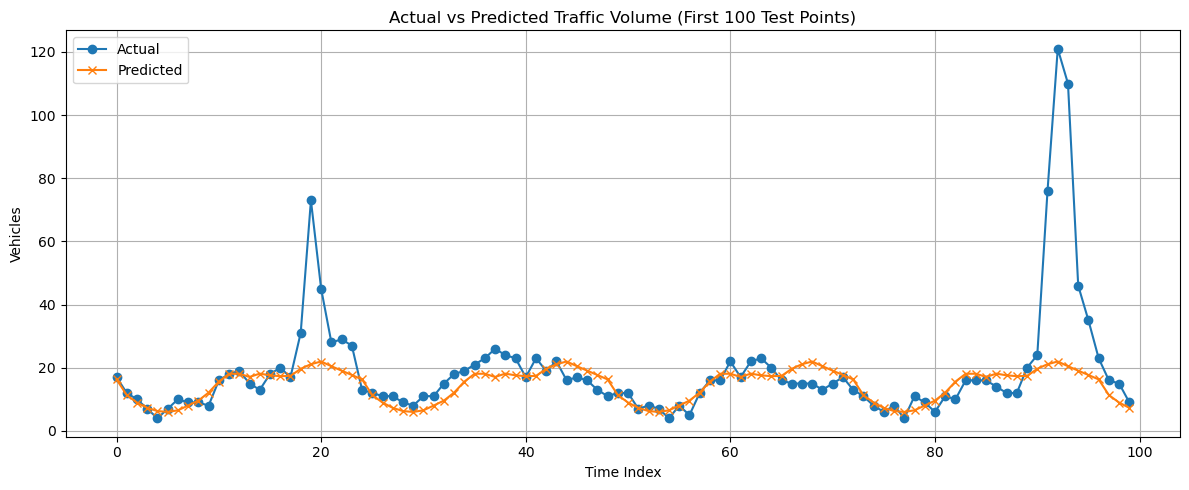

In [9]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Actual vs Predicted Traffic Volume (First 100 Test Points)')
plt.xlabel('Time Index')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from xgboost import XGBRegressor

# Update pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])

# Train and predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost] MAE: {mae_xgb:.2f}")
print(f"[XGBoost] RMSE: {rmse_xgb:.2f}")
print(f"[XGBoost] R²: {r2_xgb:.4f}")

[XGBoost] MAE: 6.31
[XGBoost] RMSE: 9.30
[XGBoost] R²: 0.1302


In [11]:
### Temporal Feature Engineering (Lag Features)

In [12]:
df['Lag_1'] = df['Vehicles'].shift(1)
df = df.dropna()  # Drop first row with NaN

# Update features
categorical_features = ['Conditions', 'Event_Name']
numerical_features = ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'WindSpeed(kmph)', 'Hour', 'Junction', 'Is_Event', 'Lag_1']
target = 'Vehicles'

X = df[categorical_features + numerical_features]
y = df[target]

# Re-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [13]:
from sklearn.model_selection import cross_val_score

cv_scores_xgb = cross_val_score(xgb_pipeline, X, y, cv=tscv, scoring='neg_mean_absolute_error')
cv_mae_scores_xgb = -cv_scores_xgb

print("XGBoost CV MAEs:", cv_mae_scores_xgb)
print(f"XGBoost Mean CV MAE: {cv_mae_scores_xgb.mean():.2f}")

XGBoost CV MAEs: [3.19433372 3.13526339 2.13100574 2.61230311 2.78634584]
XGBoost Mean CV MAE: 2.77


In [14]:
merged_df.columns

Index(['DateTime_x', 'Date', 'Hour', 'Junction', 'Vehicles', 'ID',
       'DateTime_y', 'Temperature(C)', 'Humidity(%)', 'Precipitation(mm)',
       'WindSpeed(kmph)', 'Conditions', 'Event_Name', 'Is_Event'],
      dtype='object')

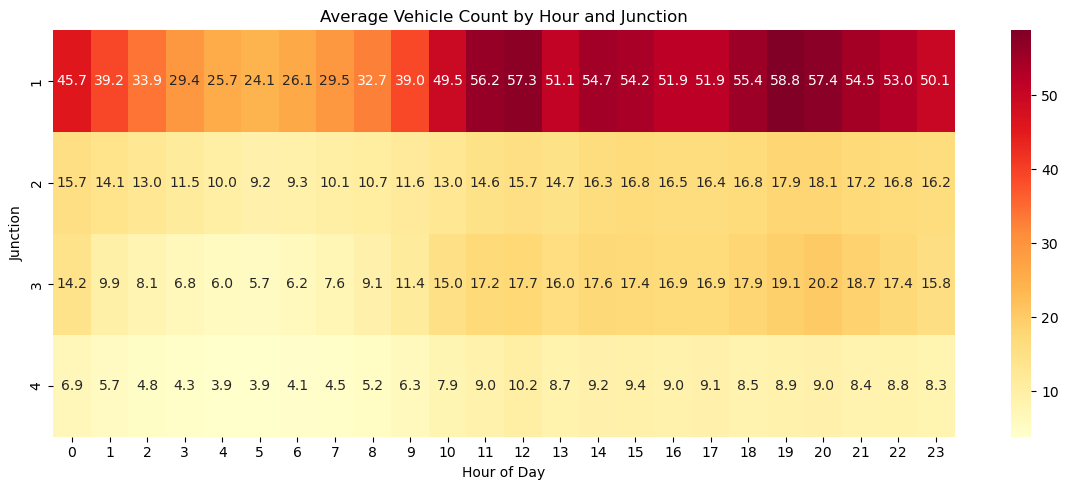

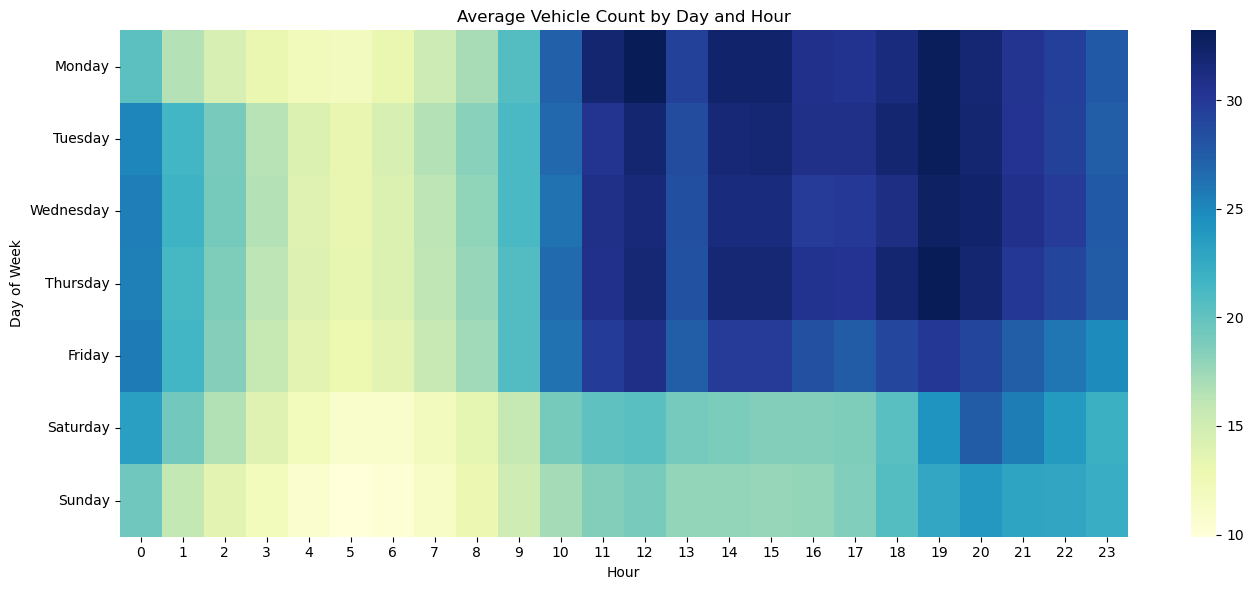

In [15]:
## Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Junction vs Hour average vehicles
hourly_avg = merged_df.groupby(['Junction', 'Hour'])['Vehicles'].mean().reset_index()
heatmap_data = hourly_avg.pivot(index='Junction', columns='Hour', values='Vehicles')

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Average Vehicle Count by Hour and Junction")
plt.xlabel("Hour of Day")
plt.ylabel("Junction")
plt.tight_layout()
plt.savefig("heatmap_peak_traffic.png")
plt.show()

# Day of week vs Hour
merged_df['DayOfWeek'] = pd.to_datetime(merged_df['Date']).dt.day_name()
dow_hour_avg = merged_df.groupby(['DayOfWeek', 'Hour'])['Vehicles'].mean().unstack().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(14, 6))
sns.heatmap(dow_hour_avg, cmap="YlGnBu", annot=False)
plt.title("Average Vehicle Count by Day and Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.savefig("day_hour_heatmap.png")
plt.show()